# Importing requisite libraries

In [1]:

import praw
import pandas as pd
import numpy as np
import time
from prawcore.exceptions import TooManyRequests
import seaborn as sns
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from transformers import RobertaTokenizer, RobertaForSequenceClassification
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from scipy.special import softmax
from nltk.tokenize import RegexpTokenizer
from collections import Counter
from nltk.corpus import opinion_lexicon
from nrclex import NRCLex
from collections import defaultdict
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import opinion_lexicon, stopwords
import matplotlib.dates as mdates
from sklearn.decomposition import LatentDirichletAllocation
import umap.umap_ as umap
from sklearn.manifold import TSNE
from nltk.corpus import opinion_lexicon, stopwords
from collections import Counter
import plotly.graph_objects as go
import networkx as nx
from IPython.display import display
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from transformers import pipeline

C:\Users\appia\anaconda3\Lib\site-packages\transformers\utils\generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


# Reddit Data Mining

In [12]:
# Reddit API credentials
CLIENT_ID = '38HWoPxbLAn3XTOwRsT3rg'
CLIENT_SECRET = 'w8KJ_Tw_NvTW9cDeyRJHqkn_rfziMQ'
USER_AGENT = 'sentiment by /u/Sure_Impression2982'

# Initialize PRAW
reddit = praw.Reddit(
    client_id=CLIENT_ID,
    client_secret=CLIENT_SECRET,
    user_agent=USER_AGENT
)

In [13]:
# Function to fetch comments with exponential backoff
def fetch_comments_with_backoff(subreddit, limit=10000):
    comments_list = []
    backoff_time = 1  # Start with a 1 second delay

    try:
        for submission in subreddit.new(limit=limit):  # Use appropriate limit
            submission.comments.replace_more(limit=10000)
            for comment in submission.comments.list():
                comments_list.append([comment.id, comment.body, comment.author.name if comment.author else 'deleted', comment.created_utc])
            time.sleep(1)  # Add delay between requests to reduce rate limit hits
    except TooManyRequests as e:
        print(f"Rate limit hit. Sleeping for {backoff_time} seconds.")
        time.sleep(backoff_time)
        backoff_time *= 2  # Exponential backoff
        return fetch_comments_with_backoff(subreddit, limit)

    return comments_list


## Subreddit 'ArtificialInteligence'

In [8]:
# Define the subreddit
subreddit_name = 'ArtificialInteligence'
subreddit = reddit.subreddit(subreddit_name)

# Fetch comments
comments_list = fetch_comments_with_backoff(subreddit, limit=5000)

# Convert to DataFrame
comments_df = pd.DataFrame(comments_list, columns=['Comment ID', 'Text', 'Author', 'Created UTC'])

# Define keywords
keywords = ['AI','Artificial Intelligence']

# Filter comments that contain the keywords
SR_AI_df = comments_df[comments_df['Text'].str.contains('|'.join(keywords), case=False, na=False)]

# Save filtered comments to a CSV file
SR_AI_df.to_csv('SR_AI_df.csv', index=False)

print("comments fetched")


comments fetched


In [9]:
# Save filtered comments to a CSV file
SR_AI_df.head()

,Comment ID,Text,Author,Created UTC
0,lazs94n,## Welcome to the r/ArtificialIntelligence gat...,AutoModerator,1.719763e+09
2,lazif33,## Welcome to the r/ArtificialIntelligence gat...,AutoModerator,1.719760e+09
4,lazfzn8,## Welcome to the r/ArtificialIntelligence gat...,AutoModerator,1.719759e+09
5,lazjaxm,In his book he defines intelligence as the com...,SignalWorldliness873,1.719760e+09
9,lazys45,In a way yes: AI is going to *augment* human's...,G4M35,1.719766e+09


In [10]:
# Save filtered comments to a CSV file
SR_AI_df.describe

<bound method NDFrame.describe of       Comment ID                                               Text  \
0        lazs94n  ## Welcome to the r/ArtificialIntelligence gat...   
2        lazif33  ## Welcome to the r/ArtificialIntelligence gat...   
4        lazfzn8  ## Welcome to the r/ArtificialIntelligence gat...   
5        lazjaxm  In his book he defines intelligence as the com...   
9        lazys45  In a way yes: AI is going to *augment* human's...   
...          ...                                                ...   
11286    l784o97  I haven’t really tested but they claim that it...   
11287    l73nhld  ## Welcome to the r/ArtificialIntelligence gat...   
11291    l77o4hk  As long as everyone involved is consenting and...   
11292    l74mc2m  > a growing space for grief-related AI technol...   
11294    l7ie4ap  I'm a journalist interested in hearing stories...   

                     Author   Created UTC  
0             AutoModerator  1.719763e+09  
2             AutoModerat

## Subreddit 'ChatGPT'

In [9]:
# Define the subreddit
subreddit_name = 'ChatGPT'
subreddit = reddit.subreddit(subreddit_name)

# Fetch comments
comments_list = fetch_comments_with_backoff(subreddit, limit=20000)

# Convert to DataFrame
comments_df = pd.DataFrame(comments_list, columns=['Comment ID', 'Text', 'Author', 'Created UTC'])

# Define keywords
keywords = ['AI', 'Artificial Inteligence']

# Filter comments that contain the keywords
SR_GPT_df = comments_df[comments_df['Text'].str.contains('|'.join(keywords), case=False, na=False)]

print("Comments fetched!")


Comments fetched!


In [10]:
# Save filtered comments to a CSV file
SR_GPT_df.to_csv('SR_GPT_df.csv', index=False)

In [11]:
SR_GPT_df.describe

<bound method NDFrame.describe of       Comment ID                                               Text  \
0        laylao0  Hey /u/interestingexistence!\n\nIf your post i...   
1        layizdo  Hey /u/Sancho4279!\n\nIf your post is a screen...   
2        layeg8f  Hey /u/Personal-Peace-9947!\n\nIf your post is...   
4        layh9vf  Hitler one is a no-brainer, but I actually wou...   
13       laye8ep  Hey /u/DaddyBezerks!\n\nIf your post is a scre...   
...          ...                                                ...   
14965    la15qws  Like I said, It can't see the exact shapes man...   
14966    la17fyh  that was as detailed a description that could ...   
14971    la0vmjj  Hey /u/JohnThePickle!\n\nIf your post is a scr...   
14974    la17qub           Character AI are funny, they are not GPT   
14977    la0yzxp  She would be a good ai, unfortunately she can'...   

                     Author   Created UTC  
0             AutoModerator  1.719744e+09  
1             AutoModerat

In [12]:
SR_GPT_df.head()

,Comment ID,Text,Author,Created UTC
0,laylao0,Hey /u/interestingexistence!\n\nIf your post i...,AutoModerator,1.719744e+09
1,layizdo,Hey /u/Sancho4279!\n\nIf your post is a screen...,AutoModerator,1.719742e+09
2,layeg8f,Hey /u/Personal-Peace-9947!\n\nIf your post is...,AutoModerator,1.719739e+09
4,layh9vf,"Hitler one is a no-brainer, but I actually wou...",strangeapple,1.719741e+09
13,laye8ep,Hey /u/DaddyBezerks!\n\nIf your post is a scre...,AutoModerator,1.719739e+09


## Subreddit 'technews'

In [11]:
# Define the subreddit
subreddit_name = 'technews'
subreddit = reddit.subreddit(subreddit_name)

# Fetch comments
comments_list = fetch_comments_with_backoff(subreddit, limit=10000)

# Convert to DataFrame
comments_df = pd.DataFrame(comments_list, columns=['Comment ID', 'Text', 'Author', 'Created UTC'])

# Define keywords
keywords = ['AI','Artificial Intelligence']

# Filter comments that contain the keywords
ai_df = comments_df[comments_df['Text'].str.contains('|'.join(keywords), case=False, na=False)]

print("comments fetched and saved")


comments fetched and saved


In [14]:
ai_df.describe

<bound method NDFrame.describe of       Comment ID                                               Text  \
6        laxsrb7  these engineers sound like people i used to do...   
18       laypolu  Yea but the article fails to state if it can L...   
26       laxdfns  Ah, yes, the Robo-Brain as made famous by the ...   
41       layrh3w  There's a paywall.  Is there any verifiable ev...   
50       layb45f  I feel like maybe humanity should collectively...   
...          ...                                                ...   
49068    kwhkqhv  Gen X here. I know this is anecdotal, but in m...   
49073    kwh32xj  Boomers who aren’t even remotely informed abou...   
49079    kwjuzro  I’m gen x and use FB more than I’d like to adm...   
49082    kwia38r  I think there's some validity to their comment...   
49083    kwia2az  I think there's some validity to their comment...   

                     Author   Created UTC  
6      Square_Extension1759  1.719724e+09  
18       FlyingSpaceOinke

In [13]:
ai_df.head()

,Comment ID,Text,Author,Created UTC
6,laxsrb7,these engineers sound like people i used to do...,Square_Extension1759,1.719724e+09
18,laypolu,Yea but the article fails to state if it can L...,FlyingSpaceOinkers,1.719747e+09
26,laxdfns,"Ah, yes, the Robo-Brain as made famous by the ...",shoe_of_bill,1.719716e+09
41,layrh3w,There's a paywall. Is there any verifiable ev...,Oswald_Hydrabot,1.719748e+09
50,layb45f,I feel like maybe humanity should collectively...,knowledgebass,1.719737e+09


In [15]:
# Save filtered comments to a CSV file
ai_df.to_csv('technews_df.csv', index=False)

## Subreddit 'artificial'

In [18]:
# Define the subreddit
subreddit_name = 'artificial'
subreddit = reddit.subreddit(subreddit_name)

# Fetch comments
comments_list = fetch_comments_with_backoff(subreddit, limit=10000)

# Convert to DataFrame
comments_df = pd.DataFrame(comments_list, columns=['Comment ID', 'Text', 'Author', 'Created UTC'])

# Define keywords
keywords = ['AI', 'Artificial Intelligence']

# Filter comments that contain the keywords
SR_Tech_df = comments_df[comments_df['Text'].str.contains('|'.join(keywords), case=False, na=False)]

print("comments fetched and saved")


comments fetched and saved


In [19]:
SR_Tech_df.describe

<bound method NDFrame.describe of       Comment ID                                               Text  \
0        lay5bx1  This happened all the time before AI wrote job...   
1        laydazm  AI isn't one thing. They are all very differen...   
2        laz5bi6  ai is not the problem.\n\npeople are the probl...   
4        laz3c7b  To be fair they did not specify the currency, ...   
5        lazbffl  This is probably one of the least annoying thi...   
...          ...                                                ...   
17872    kxqjmhk  AI learning is not *exactly* the same as human...   
17874    kxqssx1  >  AI training is exactly the same as human le...   
17875    kxr1fl1  > Is the comment that I replied to originally....   
17876    kxr40pu  > t would be a valid comparison depending cont...   
17877    kxrdrm2  > In what context is comparing simple linear a...   

                Author   Created UTC  
0           hiraeth555  1.719732e+09  
1      Nathan_Calebman  1.719738e+0

In [20]:
SR_Tech_df.head()

,Comment ID,Text,Author,Created UTC
0,lay5bx1,This happened all the time before AI wrote job...,hiraeth555,1.719732e+09
1,laydazm,AI isn't one thing. They are all very differen...,Nathan_Calebman,1.719738e+09
2,laz5bi6,ai is not the problem.\n\npeople are the probl...,Geoclasm,1.719755e+09
4,laz3c7b,"To be fair they did not specify the currency, ...",Infamous_Alpaca,1.719754e+09
5,lazbffl,This is probably one of the least annoying thi...,ivlivscaesar213,1.719757e+09


In [21]:
# Save filtered comments to a CSV file
SR_Tech_df.to_csv('artificial.csv', index=False)

## Subreddit 'tech'

In [14]:
# Define the subreddit
subreddit_name = 'tech'
subreddit = reddit.subreddit(subreddit_name)

# Fetch comments
comments_list = fetch_comments_with_backoff(subreddit, limit=10000)

# Convert to DataFrame
comments_df = pd.DataFrame(comments_list, columns=['Comment ID', 'Text', 'Author', 'Created UTC'])

# Define keywords
keywords = ['AI', 'Artificial Intelligence']

# Filter comments that contain the keywords
tech_df = comments_df[comments_df['Text'].str.contains('|'.join(keywords), case=False, na=False)]

print("comments fetched and saved")


comments fetched and saved


In [15]:
tech_df.describe

<bound method NDFrame.describe of       Comment ID                                               Text  \
0        lb8evdq  The first time I put on a pair of Vaporflys I ...   
9        lb7z6i9  Yeah, that’s an interesting idea. I would stil...   
13       lb8qll5  Occasionally for training, maybe? For competit...   
14       lb8t243  To me it was like running on a series of tiny ...   
17       lb8ipkb  They could wear springs if they wanted, I don’...   
...          ...                                                ...   
54039    jm648tc                          "artificial intelligence"   
54040    jm6tnbr                        Governments certainly won’t   
54042    jm9d56i  That’s not how ChatGPT works at all. All it’s ...   
54044    jm709il  It is, i agree. Thinking about its potential f...   
54048    jm7kje0  It's not really the death of truth, that ship ...   

                    Author   Created UTC  
0             mildpandemic  1.719891e+09  
9                   Wimtar 

In [16]:
tech_df.head()

,Comment ID,Text,Author,Created UTC
0,lb8evdq,The first time I put on a pair of Vaporflys I ...,mildpandemic,1.719891e+09
9,lb7z6i9,"Yeah, that’s an interesting idea. I would stil...",Wimtar,1.719884e+09
13,lb8qll5,"Occasionally for training, maybe? For competit...",_mully_,1.719897e+09
14,lb8t243,To me it was like running on a series of tiny ...,mildpandemic,1.719898e+09
17,lb8ipkb,"They could wear springs if they wanted, I don’...",Wimtar,1.719893e+09


In [17]:
tech_df.to_csv('tech_df.csv', index=False)

## Reddit Dataframes

####  Importing all five Reddit dataframes

In [2]:
# Load the datasets
tech_df = pd.read_csv('tech_df.csv')
artificial_df = pd.read_csv('artificial.csv')
technews_df = pd.read_csv('technews_df.csv')
SR_GPT_df = pd.read_csv('SR_GPT_df.csv')
SR_AI_df = pd.read_csv('SR_AI_df.csv')

In [3]:
# Display the first few rows of each dataframe to understand their structures
tech_df.head()


,Comment ID,Text,Author,Created UTC
0,lb8evdq,The first time I put on a pair of Vaporflys I ...,mildpandemic,1.719891e+09
1,lb7z6i9,"Yeah, that’s an interesting idea. I would stil...",Wimtar,1.719884e+09
2,lb8qll5,"Occasionally for training, maybe? For competit...",_mully_,1.719897e+09
3,lb8t243,To me it was like running on a series of tiny ...,mildpandemic,1.719898e+09
4,lb8ipkb,"They could wear springs if they wanted, I don’...",Wimtar,1.719893e+09


In [4]:
tech_df.shape

(10390, 4)

In [5]:
artificial_df.head()

,Comment ID,Text,Author,Created UTC
0,lay5bx1,This happened all the time before AI wrote job...,hiraeth555,1.719732e+09
1,laydazm,AI isn't one thing. They are all very differen...,Nathan_Calebman,1.719738e+09
2,laz5bi6,ai is not the problem.\n\npeople are the probl...,Geoclasm,1.719755e+09
3,laz3c7b,"To be fair they did not specify the currency, ...",Infamous_Alpaca,1.719754e+09
4,lazbffl,This is probably one of the least annoying thi...,ivlivscaesar213,1.719757e+09


In [6]:
artificial_df.shape

(6997, 4)

In [7]:
technews_df.head()

,Comment ID,Text,Author,Created UTC
0,laxsrb7,these engineers sound like people i used to do...,Square_Extension1759,1.719724e+09
1,laypolu,Yea but the article fails to state if it can L...,FlyingSpaceOinkers,1.719747e+09
2,laxdfns,"Ah, yes, the Robo-Brain as made famous by the ...",shoe_of_bill,1.719716e+09
3,layrh3w,There's a paywall. Is there any verifiable ev...,Oswald_Hydrabot,1.719748e+09
4,layb45f,I feel like maybe humanity should collectively...,knowledgebass,1.719737e+09


In [8]:
technews_df.shape

(11962, 4)

In [9]:
SR_GPT_df.head()

,Comment ID,Text,Author,Created UTC
0,laylao0,Hey /u/interestingexistence!\n\nIf your post i...,AutoModerator,1.719744e+09
1,layizdo,Hey /u/Sancho4279!\n\nIf your post is a screen...,AutoModerator,1.719742e+09
2,layeg8f,Hey /u/Personal-Peace-9947!\n\nIf your post is...,AutoModerator,1.719739e+09
3,layh9vf,"Hitler one is a no-brainer, but I actually wou...",strangeapple,1.719741e+09
4,laye8ep,Hey /u/DaddyBezerks!\n\nIf your post is a scre...,AutoModerator,1.719739e+09


In [10]:
SR_GPT_df.shape

(4760, 4)

In [11]:
SR_AI_df.head()

,Comment ID,Text,Author,Created UTC
0,lazs94n,## Welcome to the r/ArtificialIntelligence gat...,AutoModerator,1.719763e+09
1,lazif33,## Welcome to the r/ArtificialIntelligence gat...,AutoModerator,1.719760e+09
2,lazfzn8,## Welcome to the r/ArtificialIntelligence gat...,AutoModerator,1.719759e+09
3,lazjaxm,In his book he defines intelligence as the com...,SignalWorldliness873,1.719760e+09
4,lazys45,In a way yes: AI is going to *augment* human's...,G4M35,1.719766e+09


In [12]:
SR_AI_df.shape

(5634, 4)

### Merging all five dataframes 

In [13]:
# Standardizing the column names for consistency before merging
tech_df.columns = ['comment_id', 'text', 'author', 'created_utc']
artificial_df.columns = ['comment_id', 'text', 'author', 'created_utc']
technews_df.columns = ['comment_id', 'text', 'author', 'created_utc']
SR_GPT_df.columns = ['comment_id', 'text', 'author', 'created_utc']
SR_AI_df.columns = ['comment_id', 'text', 'author', 'created_utc']

# Merging the datasets
SR_merged_df = pd.concat([tech_df, artificial_df, technews_df, SR_GPT_df, SR_AI_df], ignore_index=True)

SR_merged_df.head()

,comment_id,text,author,created_utc
0,lb8evdq,The first time I put on a pair of Vaporflys I ...,mildpandemic,1.719891e+09
1,lb7z6i9,"Yeah, that’s an interesting idea. I would stil...",Wimtar,1.719884e+09
2,lb8qll5,"Occasionally for training, maybe? For competit...",_mully_,1.719897e+09
3,lb8t243,To me it was like running on a series of tiny ...,mildpandemic,1.719898e+09
4,lb8ipkb,"They could wear springs if they wanted, I don’...",Wimtar,1.719893e+09


In [14]:
SR_merged_df.shape

(39743, 4)

### Removing comments made by bot: 'AutoModerator'

In [15]:
# Remove comments made by the author 'AutoModerator'
SR_merged_df = SR_merged_df[SR_merged_df['author'] != 'AutoModerator']

In [16]:
SR_merged_df.head()

,comment_id,text,author,created_utc
0,lb8evdq,The first time I put on a pair of Vaporflys I ...,mildpandemic,1.719891e+09
1,lb7z6i9,"Yeah, that’s an interesting idea. I would stil...",Wimtar,1.719884e+09
2,lb8qll5,"Occasionally for training, maybe? For competit...",_mully_,1.719897e+09
3,lb8t243,To me it was like running on a series of tiny ...,mildpandemic,1.719898e+09
4,lb8ipkb,"They could wear springs if they wanted, I don’...",Wimtar,1.719893e+09


In [17]:
#  Drop the 'author' column)
SR_merged_df = SR_merged_df.drop(columns=['author'])

In [18]:
SR_merged_df.shape

(37939, 3)

In [19]:
# Filtering comments that contain the keywords "AI", "Artificial intelligence", or "Artificial inteligence"
SR_merged_df_final = SR_merged_df[SR_merged_df['text'].str.contains('AI|Artificial intelligence|Artificial inteligence', case=False, na=False)]

SR_merged_df_final.head()

,comment_id,text,created_utc
0,lb8evdq,The first time I put on a pair of Vaporflys I ...,1.719891e+09
1,lb7z6i9,"Yeah, that’s an interesting idea. I would stil...",1.719884e+09
2,lb8qll5,"Occasionally for training, maybe? For competit...",1.719897e+09
3,lb8t243,To me it was like running on a series of tiny ...,1.719898e+09
4,lb8ipkb,"They could wear springs if they wanted, I don’...",1.719893e+09


#### Converting 'created_utc' from Unix timestamp to normal datetime format

In [20]:
# Converting 'created_utc' from Unix timestamp to normal datetime format
SR_merged_df_final['created_time'] = pd.to_datetime(SR_merged_df_final['created_utc'], unit='s')

# Dropping the original 'created_utc' column
SR_merged_df_final = SR_merged_df_final.drop(columns=['created_utc'])

C:\Users\appia\AppData\Local\Temp\ipykernel_20304\49809921.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SR_merged_df_final['created_time'] = pd.to_datetime(SR_merged_df_final['created_utc'], unit='s')


In [21]:
SR_merged_df_final.head()

,comment_id,text,created_time
0,lb8evdq,The first time I put on a pair of Vaporflys I ...,2024-07-02 03:29:37
1,lb7z6i9,"Yeah, that’s an interesting idea. I would stil...",2024-07-02 01:41:35
2,lb8qll5,"Occasionally for training, maybe? For competit...",2024-07-02 05:10:04
3,lb8t243,To me it was like running on a series of tiny ...,2024-07-02 05:33:58
4,lb8ipkb,"They could wear springs if they wanted, I don’...",2024-07-02 03:59:59


In [22]:
SR_merged_df_final.shape

(37806, 3)

## Youtube Dataframe

In [23]:
# Import dataframe
youtube_df = pd.read_csv('YouTube_comments_new.csv')

In [24]:
youtube_df.head()

,video_id,comment_id,author,published_at,updated_at,like_count,text
0,l_xzUJebu_Q,Ugwkd4LHYiW2JPk5gpV4AaABAg,@nicolas-lb4kd,2024-07-13T18:52:53Z,2024-07-13T18:52:53Z,1,Future niche &quot;Training a thief Robot&quot...
1,l_xzUJebu_Q,UgxJs5ViA6PlshoddvJ4AaABAg,@JohnSmith-t7g,2024-07-12T17:44:11Z,2024-07-12T17:44:11Z,0,it seems like AI will replace white collar job...
2,l_xzUJebu_Q,Ugwk1hqPav-sk7S1p1l4AaABAg,@curtcoller3632,2024-07-12T05:42:24Z,2024-07-12T05:42:24Z,0,"AI is racism, lol."
3,l_xzUJebu_Q,UgwqQb-6uiWu5AeminR4AaABAg,@Phillip-dw7vr,2024-07-10T20:44:45Z,2024-07-10T20:44:45Z,0,Thank God. I hope it comes to McDonalds. Sick ...
4,l_xzUJebu_Q,UgxCIpREnE7cHOkNCvN4AaABAg,@saptarshichowdhury9138,2024-07-10T09:40:17Z,2024-07-10T09:40:17Z,0,ai wont be our slaves they will be our masters


In [25]:
youtube_df.shape

(89662, 7)

In [26]:
#  Drop the 'author' column)
youtube_df = youtube_df.drop(columns=['author'])

In [27]:
# Convert the 'created_time' column to datetime
youtube_df['updated_at'] = pd.to_datetime(youtube_df['updated_at'])

# Remove the timezone information
youtube_df['updated_at'] = youtube_df['updated_at'].dt.tz_localize(None)

In [28]:
# Dropping the specified columns and renaming 'updated_at' to 'created_time'
youtube_df.drop(columns=['comment_id', 'published_at', 'like_count'], inplace=True)
youtube_df.rename(columns={'updated_at': 'created_time'}, inplace=True)

In [29]:
# Display the first few rows to confirm the changes
youtube_df.head()

,video_id,created_time,text
0,l_xzUJebu_Q,2024-07-13 18:52:53,Future niche &quot;Training a thief Robot&quot...
1,l_xzUJebu_Q,2024-07-12 17:44:11,it seems like AI will replace white collar job...
2,l_xzUJebu_Q,2024-07-12 05:42:24,"AI is racism, lol."
3,l_xzUJebu_Q,2024-07-10 20:44:45,Thank God. I hope it comes to McDonalds. Sick ...
4,l_xzUJebu_Q,2024-07-10 09:40:17,ai wont be our slaves they will be our masters


### Merging the Reddit Dataframe with the YouTube Dataframe

In [30]:
# Merge two dataframes and view first few rows
RD_YT_df = pd.concat([youtube_df, SR_merged_df_final], ignore_index=True)

In [31]:
#  Drop the 'author' column)
RD_YT_df = RD_YT_df.drop(columns=['comment_id'])

In [32]:
RD_YT_df.head()

,video_id,created_time,text
0,l_xzUJebu_Q,2024-07-13 18:52:53,Future niche &quot;Training a thief Robot&quot...
1,l_xzUJebu_Q,2024-07-12 17:44:11,it seems like AI will replace white collar job...
2,l_xzUJebu_Q,2024-07-12 05:42:24,"AI is racism, lol."
3,l_xzUJebu_Q,2024-07-10 20:44:45,Thank God. I hope it comes to McDonalds. Sick ...
4,l_xzUJebu_Q,2024-07-10 09:40:17,ai wont be our slaves they will be our masters


In [33]:
RD_YT_df.shape

(127468, 3)

## Tweets

In [34]:
# Import dataframe
twitter_df = pd.read_csv('tweets.csv')

In [35]:
twitter_df.head()

,id,content,date
0,1660091546161620000,'Heart wrenching': #AI #expert details #danger...,2023-05-21 01:14:02+00:00
1,1660088677630970000,When the Default happens #DebtCeilingCrisis YE...,2023-05-21 01:02:38+00:00
2,1660088378816180000,Checkout the latest updates from David Estrada...,2023-05-21 01:01:27+00:00
3,1660087769895450000,Opinion: #CambridgeAnalytica on steroids: \n\n...,2023-05-21 00:59:01+00:00
4,1660087570141720000,This nimble quadruped is designed to be a pet ...,2023-05-21 00:58:14+00:00


In [36]:
twitter_df.shape

(5536, 3)

In [37]:
# Convert the 'created_time' column to datetime
twitter_df['date'] = pd.to_datetime(twitter_df['date'])

# Remove the timezone information
twitter_df['date'] = twitter_df['date'].dt.tz_localize(None)

In [38]:
twitter_df.head()

,id,content,date
0,1660091546161620000,'Heart wrenching': #AI #expert details #danger...,2023-05-21 01:14:02
1,1660088677630970000,When the Default happens #DebtCeilingCrisis YE...,2023-05-21 01:02:38
2,1660088378816180000,Checkout the latest updates from David Estrada...,2023-05-21 01:01:27
3,1660087769895450000,Opinion: #CambridgeAnalytica on steroids: \n\n...,2023-05-21 00:59:01
4,1660087570141720000,This nimble quadruped is designed to be a pet ...,2023-05-21 00:58:14


In [39]:
# Standardizing headings
twitter_df.columns = ['comment_id', 'text', 'created_time']

### Merging the Reddit, YouTube and Twitter Dataframe

In [40]:
# Merge all dataframes and view first few rows
RD_YT_TD_df = pd.concat([youtube_df, SR_merged_df_final, twitter_df], ignore_index=True)
RD_YT_TD_df.head()

,video_id,created_time,text,comment_id
0,l_xzUJebu_Q,2024-07-13 18:52:53,Future niche &quot;Training a thief Robot&quot...,NaN
1,l_xzUJebu_Q,2024-07-12 17:44:11,it seems like AI will replace white collar job...,NaN
2,l_xzUJebu_Q,2024-07-12 05:42:24,"AI is racism, lol.",NaN
3,l_xzUJebu_Q,2024-07-10 20:44:45,Thank God. I hope it comes to McDonalds. Sick ...,NaN
4,l_xzUJebu_Q,2024-07-10 09:40:17,ai wont be our slaves they will be our masters,NaN


In [41]:
#  Drop the 'comment_id' column)
RD_YT_TD_df = RD_YT_TD_df.drop(columns=['comment_id', 'video_id'])

In [42]:
RD_YT_TD_df.shape

(133004, 2)

In [43]:
#Final data frame has 133004

In [44]:
# Save filtered comments to a CSV file
RD_YT_TD_df.to_csv('RD_YT_TD_df.csv', index=False)

# Data Preprocessing

In [2]:
# Import dataframe
final_df = pd.read_csv('RD_YT_TD_df.csv')

In [3]:
final_df.head()

,created_time,text
0,2024-07-13 18:52:53,Future niche &quot;Training a thief Robot&quot...
1,2024-07-12 17:44:11,it seems like AI will replace white collar job...
2,2024-07-12 05:42:24,"AI is racism, lol."
3,2024-07-10 20:44:45,Thank God. I hope it comes to McDonalds. Sick ...
4,2024-07-10 09:40:17,ai wont be our slaves they will be our masters


In [4]:
final_df.shape

(133004, 2)

In [5]:
# Data cleaning Function
def clean_text(text):
    # Convert to lowercase
    text = text.lower()
    
    # Removing URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Removing HTML tags
    text = re.sub(r'<.*?>', '', text)
    
    # Removing non-alphabetic characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
     # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text)
    
    # Strip leading and trailing whitespace
    text = text.strip()
    
    # Tokenization
    tokens = word_tokenize(text)
    
    # Join tokens back to string
    cleaned_text = ' '.join(tokens)
    
    return cleaned_text

In [6]:
# Applying the clean_text function to the 'text' column of final_df
final_df['clean_text'] = final_df['text'].apply(clean_text)

In [7]:
final_df = final_df.dropna(axis=1)

In [8]:
final_df.shape

(133004, 3)

In [9]:
final_df.head()

,created_time,text,clean_text
0,2024-07-13 18:52:53,Future niche &quot;Training a thief Robot&quot...,future niche quottraining a thief robotquot lol
1,2024-07-12 17:44:11,it seems like AI will replace white collar job...,it seems like ai will replace white collar job...
2,2024-07-12 05:42:24,"AI is racism, lol.",ai is racism lol
3,2024-07-10 20:44:45,Thank God. I hope it comes to McDonalds. Sick ...,thank god i hope it comes to mcdonalds sick an...
4,2024-07-10 09:40:17,ai wont be our slaves they will be our masters,ai wont be our slaves they will be our masters


# EDA

### Word Cloud

In [20]:
# Define your custom stopwords
custom_stopwords = {'im','t','doe', 'href', 'theyre', 'lol','Im','isnt','theres','dont','ye','amp','wouldnt','didnt','youre','na','gon','quot','m',
                   's'}

# Combine existing stopwords with your custom stopwords
stopwords = ENGLISH_STOP_WORDS.union(custom_stopwords)

# Combine all text data into a single string
text = " ".join(final_df['clean_text'])

# Generate word cloud without stop words
wordcloud = WordCloud(stopwords=stopwords, background_color="white", width=1000, height=1300).generate(text)

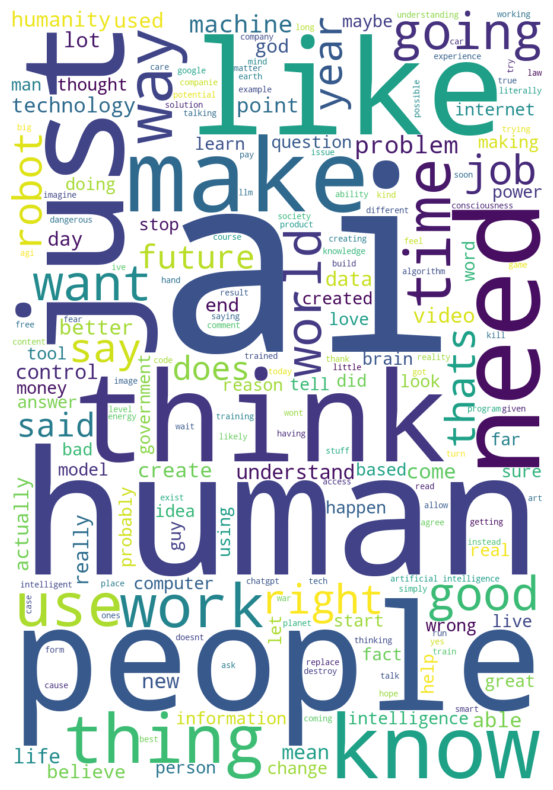

In [22]:
# Display the generated word cloud
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [15]:
# Define your custom stop words
CUSTOM_STOP_WORDS = {'im','doe', 'href', 'theyre', 'lol','Im','isnt','theres','dont','ye','amp','wouldnt','didnt','youre','na','gon','just','thats'
                    ,'going','things'}  
ENGLISH_STOP_WORDS = set(ENGLISH_STOP_WORDS)
ALL_STOP_WORDS = ENGLISH_STOP_WORDS.union(CUSTOM_STOP_WORDS) 

# Create a counter for the words
word_counts = Counter(text.split())

In [16]:
# Remove stop words
filtered_words = {word: count for word, count in word_counts.items() if word.lower() not in ALL_STOP_WORDS}

# Get the top 20 most common words
top_20_words = dict(Counter(filtered_words).most_common(20))

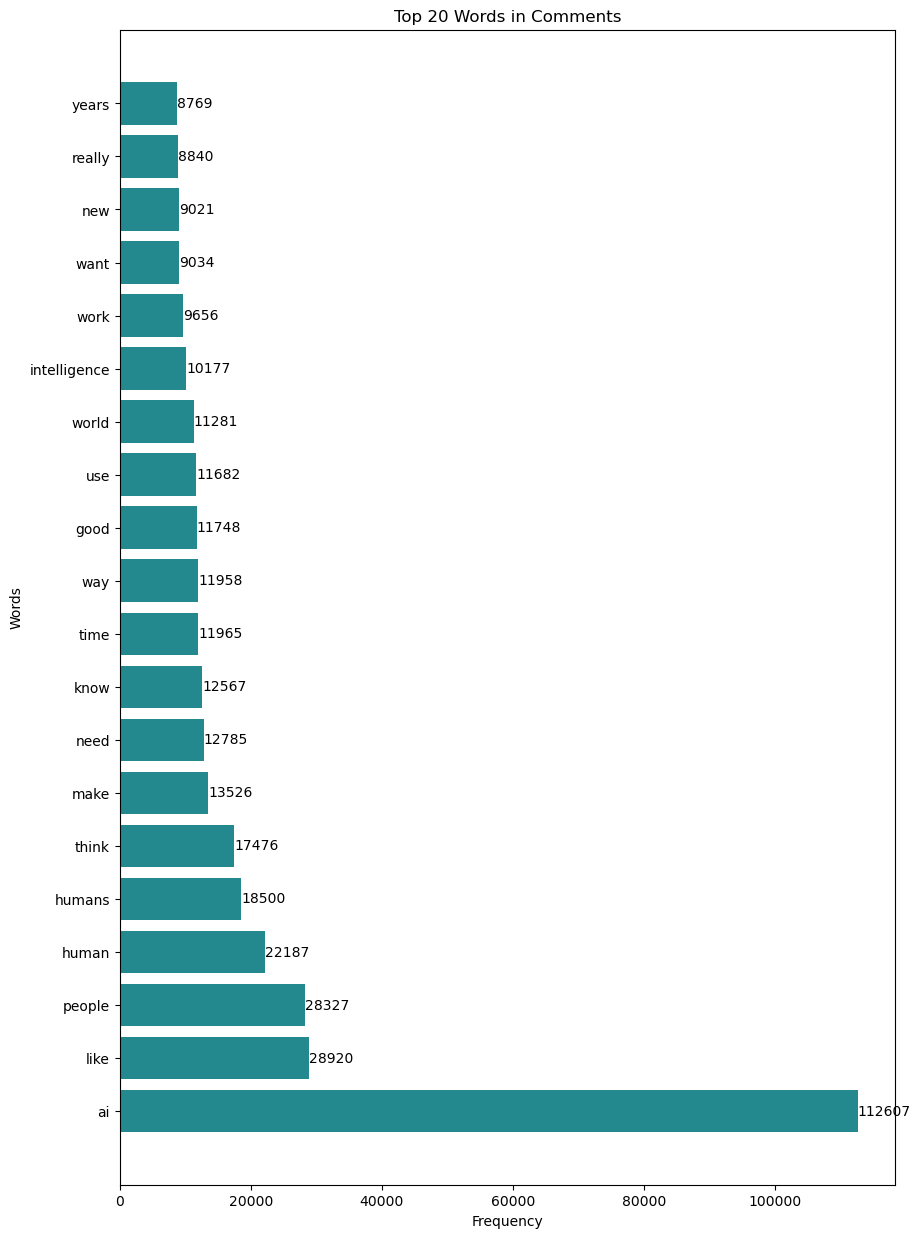

In [17]:
# Plotting the top 20 words
plt.figure(figsize=(10, 15))
bars = plt.barh(list(top_20_words.keys()), list(top_20_words.values()), color='#23898e')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.title('Top 20 Words in Comments')

# Add values next to the bars
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, f'{bar.get_width()}', va='center')

plt.show()

In [15]:
# Save filtered comments to a CSV file
final_df.to_csv('data1.csv', index=False)

# Data Analyis

### roBERTA Model

In [2]:
# Import dataframe
final_df = pd.read_csv('data1.csv')

In [17]:
# Load the model and tokenizer
task = 'sentiment'
MODEL = f"cardiffnlp/twitter-roberta-base-{task}"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [18]:
# Move the model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [19]:
# Function to predict sentiment
def predict_sentiment(text):
    # Tokenize the input text with truncation
    encoded_input = tokenizer(text, return_tensors='pt', truncation=True, max_length=512).to(device)
    with torch.no_grad():
        output = model(**encoded_input)
    scores = output[0][0].cpu().numpy()
    scores = softmax(scores)
    # Find the index of the highest score
    class_idx = scores.argmax()
    # Map index to class label
    if class_idx == 0:
        return 'negative'
    elif class_idx == 1:
        return 'neutral'
    else:
        return 'positive'

In [6]:
# Ensure all entries in 'clean_text' are strings and handle non-string values
final_df['clean_text'] = final_df['clean_text'].astype(str)

In [22]:
# Apply sentiment prediction
final_df['sentiment'] = final_df['clean_text'].apply(predict_sentiment)

In [23]:
final_df.head()

,created_time,text,clean_text,sentiment
0,2024-07-13 18:52:53,Future niche &quot;Training a thief Robot&quot...,future niche quottraining a thief robotquot lol,neutral
1,2024-07-12 17:44:11,it seems like AI will replace white collar job...,it seems like ai will replace white collar job...,neutral
2,2024-07-12 05:42:24,"AI is racism, lol.",ai is racism lol,negative
3,2024-07-10 20:44:45,Thank God. I hope it comes to McDonalds. Sick ...,thank god i hope it comes to mcdonalds sick an...,negative
4,2024-07-10 09:40:17,ai wont be our slaves they will be our masters,ai wont be our slaves they will be our masters,neutral


In [24]:
print(final_df['sentiment'].value_counts())

sentiment
negative    61302
neutral     52256
positive    19446
Name: count, dtype: int64


In [25]:
# Save filtered comments to a CSV file
final_df.to_csv('data2.csv', index=False)

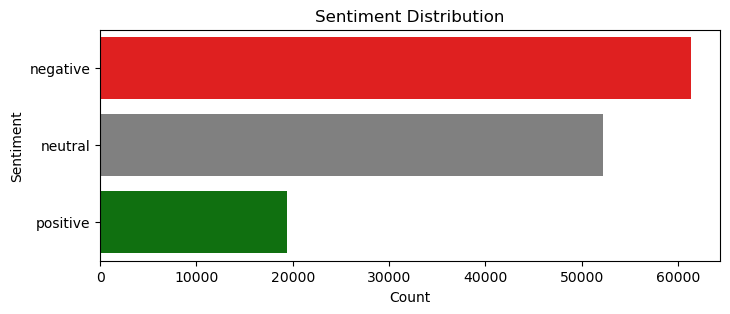

In [26]:
# Count the number of each sentiment
sentiment_counts = final_df['sentiment'].value_counts().reset_index()
sentiment_counts.columns = ['sentiment', 'count']

# Plot the horizontal bar chart using Seaborn
plt.figure(figsize=(8, 3))
sns.barplot(y='sentiment', x='count', data=sentiment_counts, palette=['red', 'gray', 'green'])
plt.title('Sentiment Distribution')
plt.xlabel('Count')
plt.ylabel('Sentiment')
plt.show()


### Creating the top 10 most frequent words in terms of negative/positive sentiments in the text and their word cloud

In [2]:
# Load the dataset
file_path = 'data2.csv'
final_df = pd.read_csv(file_path)

In [3]:
# Download necessary NLTK data
nltk.download('opinion_lexicon')
nltk.download('stopwords')

[nltk_data] Downloading package opinion_lexicon to
[nltk_data]     C:\Users\appia\AppData\Roaming\nltk_data...
[nltk_data]   Package opinion_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\appia\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
# Ensure all entries in 'clean_text' are strings and handle non-string values
final_df['clean_text'] = final_df['clean_text'].astype(str)

In [5]:
# Function to tokenize text and get word frequencies
def get_word_frequencies(texts, sentiment_words=None):
    all_words = ' '.join(texts).lower()
    words = re.findall(r'\b\w+\b', all_words)  # Simple word tokenization
    if sentiment_words:
        words = [word for word in words if word in sentiment_words]
    word_counts = Counter(words)
    return word_counts

# Define lists of positive, negative, and neutral words using NLTK's opinion lexicon
positive_sentiment_words = set(opinion_lexicon.positive())
negative_sentiment_words = set(opinion_lexicon.negative())
stop_words = set(stopwords.words('english'))

all_words = set(re.findall(r'\b\w+\b', ' '.join(final_df['clean_text']).lower()))
neutral_sentiment_words = all_words - positive_sentiment_words - negative_sentiment_words - stop_words


In [6]:
# Get word frequencies for each sentiment category
positive_texts = final_df[final_df['sentiment'] == 'positive']['clean_text']
negative_texts = final_df[final_df['sentiment'] == 'negative']['clean_text']
neutral_texts = final_df[final_df['sentiment'] == 'neutral']['clean_text']

positive_word_freq = get_word_frequencies(positive_texts, positive_sentiment_words)
negative_word_freq = get_word_frequencies(negative_texts, negative_sentiment_words)
neutral_word_freq = get_word_frequencies(neutral_texts, neutral_sentiment_words)

In [7]:
# Get the top 10 most frequent words for each category
top_positive_words = positive_word_freq.most_common(10)
top_negative_words = negative_word_freq.most_common(10)
top_neutral_words = neutral_word_freq.most_common(10)

In [8]:
# Data for plotting
positive_words, positive_counts = zip(*top_positive_words)
negative_words, negative_counts = zip(*top_negative_words)
neutral_words, neutral_counts = zip(*top_neutral_words)


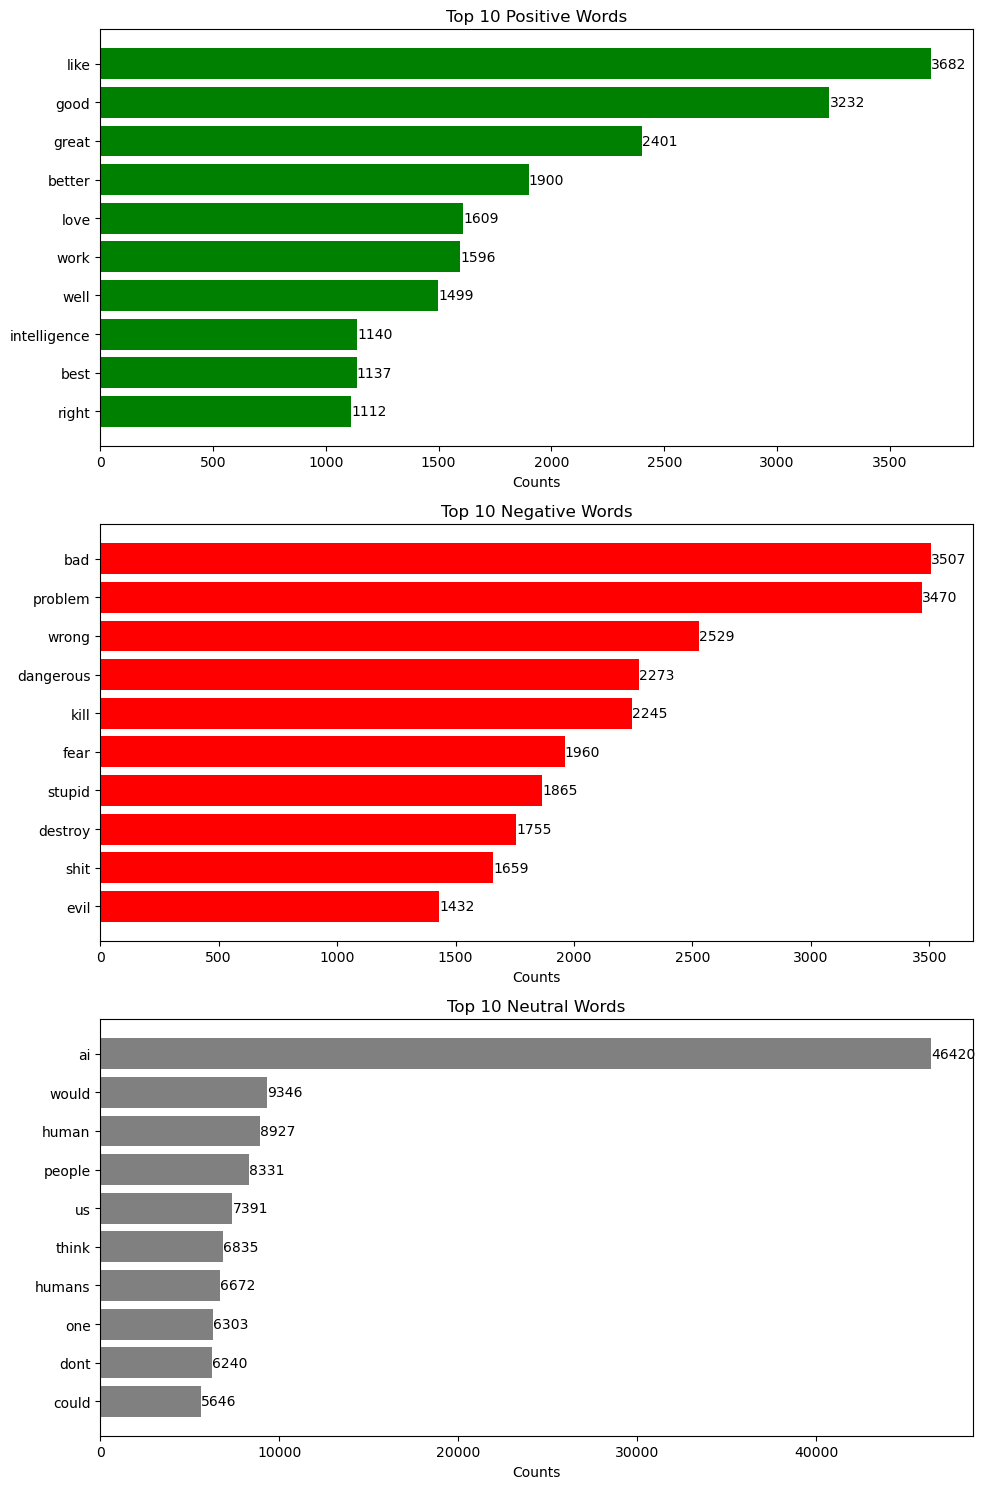

In [9]:
# Define colormaps
positive_colors = ['green'] * len(positive_words)
negative_colors = ['red'] * len(negative_words)
neutral_colors = ['gray'] * len(neutral_words) 

# Plotting the bar chart for top 10 words
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

# Bar chart for positive words
bars = axs[0].barh(positive_words, positive_counts, color=positive_colors)
axs[0].set_title('Top 10 Positive Words')
axs[0].set_xlabel('Counts')
axs[0].invert_yaxis()
for bar in bars:
    width = bar.get_width()
    axs[0].text(width, bar.get_y() + bar.get_height() / 2, str(int(width)), va='center')

# Bar chart for negative words
bars = axs[1].barh(negative_words, negative_counts, color=negative_colors)
axs[1].set_title('Top 10 Negative Words')
axs[1].set_xlabel('Counts')
axs[1].invert_yaxis()
for bar in bars:
    width = bar.get_width()
    axs[1].text(width, bar.get_y() + bar.get_height() / 2, str(int(width)), va='center')

# Bar chart for neutral words
bars = axs[2].barh(neutral_words, neutral_counts, color=neutral_colors)
axs[2].set_title('Top 10 Neutral Words')
axs[2].set_xlabel('Counts')
axs[2].invert_yaxis()
for bar in bars:
    width = bar.get_width()
    axs[2].text(width, bar.get_y() + bar.get_height() / 2, str(int(width)), va='center')

# Adjust layout
plt.tight_layout()
plt.show()


In [10]:
# Generate word clouds for all positive, negative, and neutral words
positive_wordcloud = WordCloud(width=1000, height=600, background_color='white').generate_from_frequencies(positive_word_freq)
negative_wordcloud = WordCloud(width=1000, height=600, background_color='white').generate_from_frequencies(negative_word_freq)
neutral_wordcloud = WordCloud(width=1000, height=600, background_color='white').generate_from_frequencies(neutral_word_freq)

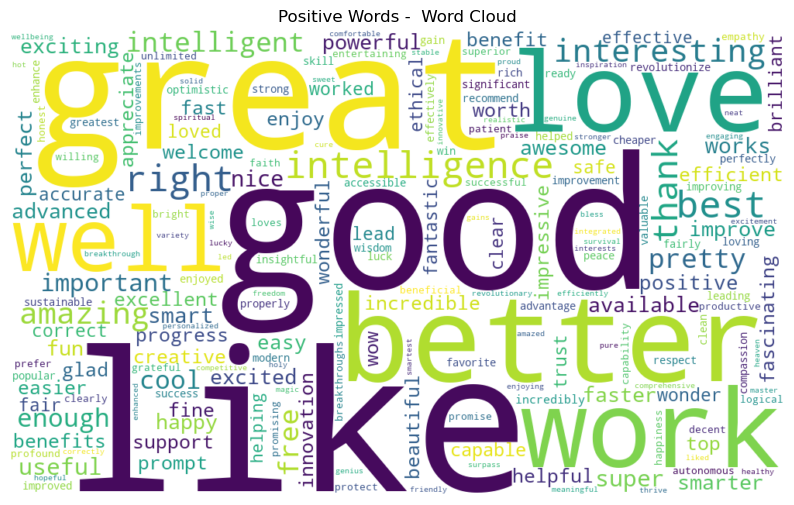

In [11]:
# Display the positive word cloud
plt.figure(figsize=(10, 8))
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Positive Words -  Word Cloud')
plt.show()

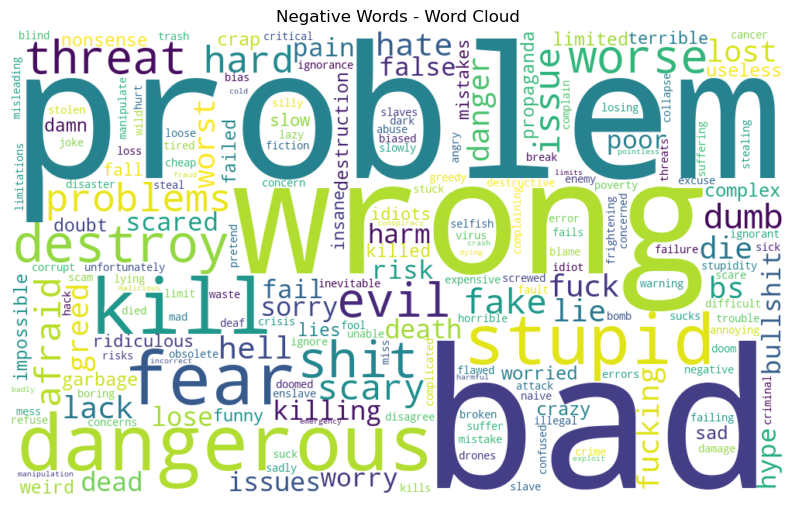

In [12]:
# Display the negative word cloud
plt.figure(figsize=(10, 8))
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Negative Words - Word Cloud')
plt.show()

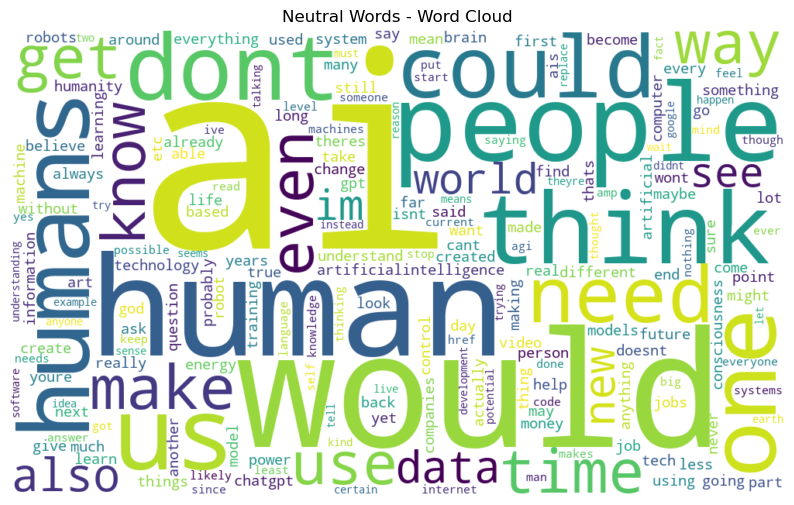

In [13]:
# Display the neutral word cloud
plt.figure(figsize=(10, 8))
plt.imshow(neutral_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Neutral Words - Word Cloud')
plt.show()

# Model Ealuation

In [2]:
# Load test dataset
dataset_path = 'test.csv'
df = pd.read_csv(dataset_path)

In [3]:
# Map sentiments to numeric values
label_map = {'negative': 0, 'neutral': 1, 'positive': 2}
df['label'] = df['sentiment'].map(label_map)

In [4]:
# Preprocessing function
def preprocess_text(text):
    if pd.isna(text):
        return ''
    text = str(text).lower()  # Convert to string and lowercase
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'@\w+', '', text)  # Remove mentions
    text = re.sub(r'#\w+', '', text)  # Remove hashtags
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)  # Remove special characters
    return text

# Apply preprocessing
df['text'] = df['text'].apply(preprocess_text)

In [7]:
# Load the model and tokenizer
model_name = 'cardiffnlp/twitter-roberta-base-sentiment-latest'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Initialize the sentiment analysis pipeline
nlp = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [8]:
# Function to map model output to labels
def get_label(sentiment_result):
    label_map = {'negative': 0, 'neutral': 1, 'positive': 2}
    return label_map[sentiment_result['label']]

In [9]:
# Predict sentiments
df['predicted_label'] = df['text'].apply(lambda x: get_label(nlp(x)[0]))

In [10]:
# Evaluate the model
accuracy = accuracy_score(df['label'], df['predicted_label'])
report = classification_report(df['label'], df['predicted_label'], target_names=['negative', 'neutral', 'positive'])

print(f'Accuracy: {accuracy:.2f}')
print('Classification Report:')
print(report)

Accuracy: 0.74
Classification Report:
              precision    recall  f1-score   support

    negative       0.74      0.82      0.78       153
     neutral       0.77      0.60      0.68       200
    positive       0.72      0.86      0.79       147

    accuracy                           0.74       500
   macro avg       0.74      0.76      0.75       500
weighted avg       0.75      0.74      0.74       500



#### Confusion Matrix

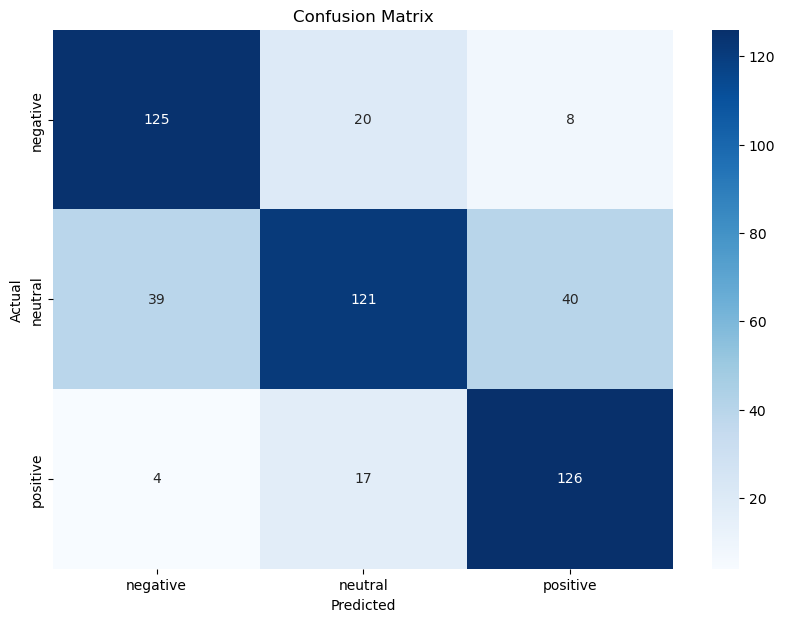

In [13]:
# Generate confusion matrix
conf_matrix = confusion_matrix(df['label'], df['predicted_label'])

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['negative', 'neutral', 'positive'], yticklabels=['negative', 'neutral', 'positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Topic Modelling

### LDA Model

In [14]:
# Custom stop words
custom_stop_words = ['gon', 'na', 'im', 'ive', 'href']

# Download stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english')).union(custom_stop_words)
stop_words = list(stop_words)  # Convert stop_words to a list

# Vectorization
vectorizer = CountVectorizer(stop_words=stop_words, max_df=0.95, min_df=2)
texts = final_df['clean_text'].values
dtm = vectorizer.fit_transform(texts)

# Apply LDA
num_topics = 20
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda.fit(dtm)

# Display topics
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 20
display_topics(lda, vectorizer.get_feature_names_out(), no_top_words)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\appia\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Topic 0:
ai artificialintelligence technology chatgpt machinelearning future potential tech artificial intelligence amp generative new datascience midjourney robotics art via ml using
Topic 1:
god ai people life like jesus us know one love believe world evil created gods man dont christ beast spirit
Topic 2:
could energy data would brain also new research system power space make one cells process systems great theory used light
Topic 3:
ai man future good fear love afraid great world one said quot guy mo like thank day end come podcast
Topic 4:
ai video wait years hes cant said great real ago thank well oh software thanks future like made till good
Topic 5:
data intelligence ai models model learning agi like training machine gpt artificial llms language think even human current based much
Topic 6:
ai human humans would intelligence us consciousness intelligent like could think even never may way become life conscious emotions artificial
Topic 7:
like google people ai internet time sear

In [15]:
doc_topic_distributions = lda.transform(dtm)

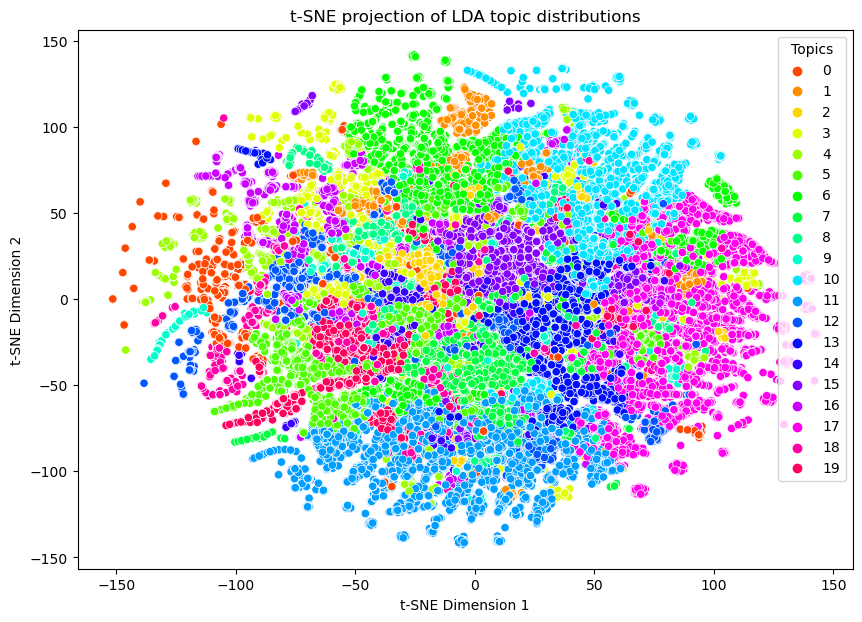

In [33]:
# t-SNE Visualization
tsne_model = TSNE(n_components=2, random_state=42)
tsne_embeddings = tsne_model.fit_transform(doc_topic_distributions)

plt.figure(figsize=(10, 7))
sns.scatterplot(x=tsne_embeddings[:,0], y=tsne_embeddings[:,1], hue=np.argmax(doc_topic_distributions, axis=1), palette=sns.color_palette("hsv", num_topics))
plt.title('t-SNE projection of LDA topic distributions')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend(title='Topics', loc='upper right')
plt.show()

## NGRAM Modelling

In [53]:
from scipy.sparse import csr_matrix

# Custom stop words
custom_stop_words = ['gon', 'na', 'im', 'ive', 'href']

# Download stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english')).union(custom_stop_words)
stop_words = list(stop_words)  # Convert stop_words to a list

# Ensure texts is a list of strings
texts = final_df['clean_text'].tolist()

# Function to generate n-grams using CountVectorizer
def get_ngrams(texts, n, stop_words):
    vectorizer = CountVectorizer(ngram_range=(n, n), stop_words=stop_words)
    ngrams = vectorizer.fit_transform(texts)
    ngrams_freq = ngrams.sum(axis=0).A1  # Use sparse matrix summation
    ngrams_vocab = vectorizer.vocabulary_
    ngrams_list = [(ngram, ngrams_freq[idx]) for ngram, idx in ngrams_vocab.items()]
    return sorted(ngrams_list, key=lambda x: x[1], reverse=True)

# Generate unigrams, bigrams, and trigrams frequencies
unigram_freq_list = get_ngrams(texts, 1, stop_words)
bigram_freq_list = get_ngrams(texts, 2, stop_words)
trigram_freq_list = get_ngrams(texts, 3, stop_words)

# Convert to DataFrames for better visualization
unigram_freq_df = pd.DataFrame(unigram_freq_list, columns=['Unigram', 'Frequency'])
bigram_freq_df = pd.DataFrame(bigram_freq_list, columns=['Bigram', 'Frequency'])
trigram_freq_df = pd.DataFrame(trigram_freq_list, columns=['Trigram', 'Frequency'])

# Display the DataFrames
print(unigram_freq_df)
print(bigram_freq_df)
print(trigram_freq_df)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\appia\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


             Unigram  Frequency
0                 ai     112607
1               like      28920
2             people      28327
3              human      22187
4              would      21960
...              ...        ...
128504   scienceosai          1
128505     mayflower          1
128506      plymouth          1
128507  griefrelated          1
128508      micheals          1

[128509 rows x 2 columns]
                          Bigram  Frequency
0        artificial intelligence       2959
1                      dont know       2023
2                     dont think       1738
3                         use ai       1597
4                       ai would       1536
...                          ...        ...
1929197    journalist interested          1
1929198            like micheals          1
1929199          micheals anyone          1
1929200          within grieving          1
1929201               process id          1

[1929202 rows x 2 columns]
                            Trigr

### Word co-occurrence mapping

In [55]:
# Filter bigrams with over 400 interactions
filtered_bigrams = bigram_freq_df[bigram_freq_df['Frequency'] > 350]

# Create a directed graph
G = nx.DiGraph()

# Add edges to the graph
for index, row in filtered_bigrams.iterrows():
    words = row['Bigram'].split()
    if len(words) == 2:
        G.add_edge(words[0], words[1])

# Get positions for the nodes
pos = nx.spring_layout(G, k=1.0)

# Create edge traces
edge_trace = []
for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_trace.append(go.Scatter(
        x=[x0, x1, None],
        y=[y0, y1, None],
        line=dict(width=0.6, color='#1f78b4'),
        hoverinfo='none',
        mode='lines'))

# Create node traces
node_trace = go.Scatter(
    x=[],
    y=[],
    text=[],
    mode='markers+text',
    textposition="top center",
    hoverinfo='text',
    marker=dict(
        showscale=False,
        color='white',
        size=10,
        line=dict(width=2, color='black')
    )
)

for node in G.nodes():
    x, y = pos[node]
    node_trace['x'] += tuple([x])
    node_trace['y'] += tuple([y])
    node_trace['text'] += tuple([node])

# Create the figure with increased size
fig = go.Figure(data=edge_trace + [node_trace],
                layout=go.Layout(
                    title='Word co-occurrence diagrams of Bigrams with Over 350 Interactions',
                    titlefont=dict(size=15),
                    showlegend=False,
                    hovermode='closest',
                    margin=dict(b=20, l=5, r=5, t=40),
                    annotations=[dict(
                        text="",
                        showarrow=True,
                        xref="paper", yref="paper"
                    )],
                    xaxis=dict(showgrid=True, zeroline=False),
                    yaxis=dict(showgrid=True, zeroline=False),
                    width=1200, 
                    height=1200   
                )
)

fig.show()


In [102]:
# Save filtered comments to a CSV file
final_df.to_csv('data3.csv', index=False)

## Timeline Analysis and Sentiment Change

#### Basic EDA

In [3]:
# Load the dataset
file_path = 'data3.csv'
df = pd.read_csv(file_path)

In [4]:
df.head()

,created_time,text,clean_text,sentiment,classification
0,2024-07-13 18:52:53,Future niche &quot;Training a thief Robot&quot...,future niche quottraining thief robotquot lol,neutral,negative
1,2024-07-12 17:44:11,it seems like AI will replace white collar job...,seems like ai replace white collar jobs first ...,neutral,positive
2,2024-07-12 05:42:24,"AI is racism, lol.",ai racism lol,negative,neutral
3,2024-07-10 20:44:45,Thank God. I hope it comes to McDonalds. Sick ...,thank god hope comes mcdonalds sick tired talk...,negative,positive
4,2024-07-10 09:40:17,ai wont be our slaves they will be our masters,ai wont slaves masters,neutral,positive


In [123]:
# Basic EDA
# Convert created_time to datetime
df['created_time'] = pd.to_datetime(df['created_time'])

# Group by year and count the number of comments
df['year'] = df['created_time'].dt.to_period('Y')
annual_counts_all = df.groupby('year').size().reset_index(name='count')

# Convert year to string for plotting
annual_counts_all['year'] = annual_counts_all['year'].astype(str)

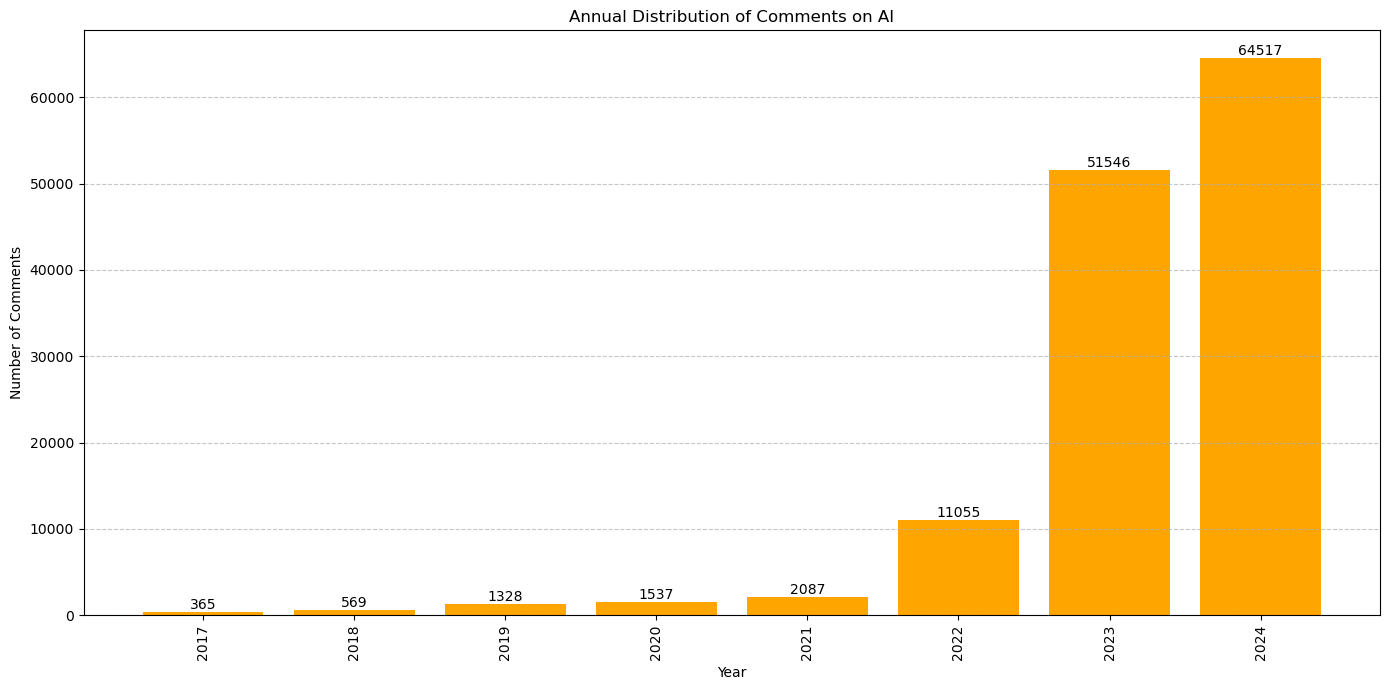

In [124]:
# Plot the annual counts as a bar chart with vertical rotation and values at the end of each bar
plt.figure(figsize=(14, 7))
bars = plt.bar(annual_counts_all['year'], annual_counts_all['count'], color='orange')
plt.xticks(rotation=90)
plt.xlabel('Year')
plt.ylabel('Number of Comments')
plt.title('Annual Distribution of Comments on AI')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Add values at the end of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')

plt.show()

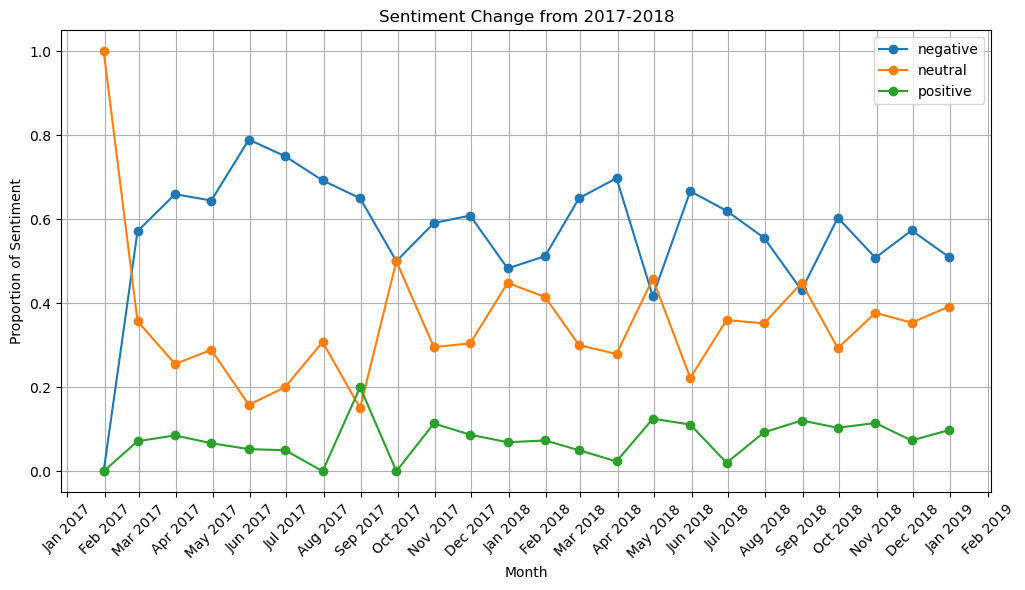

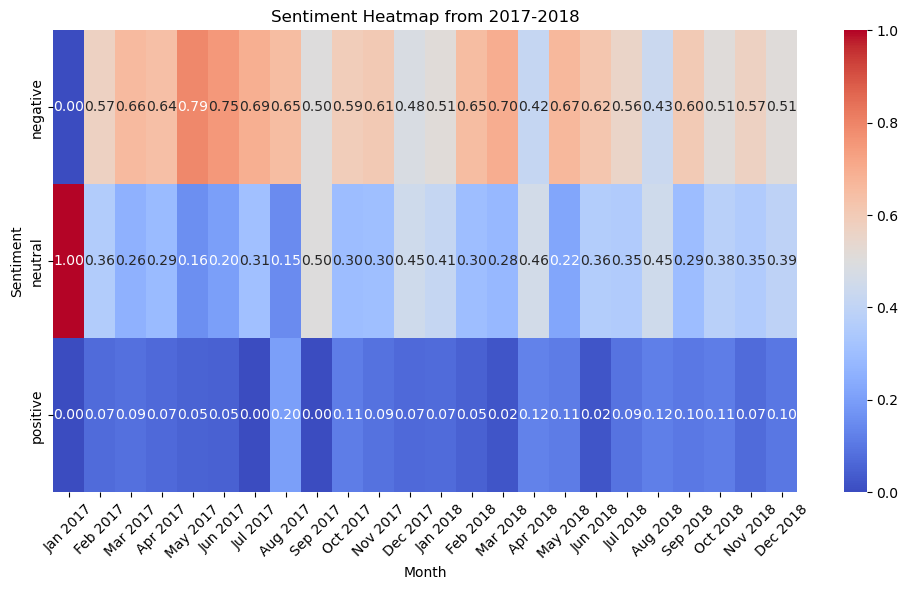

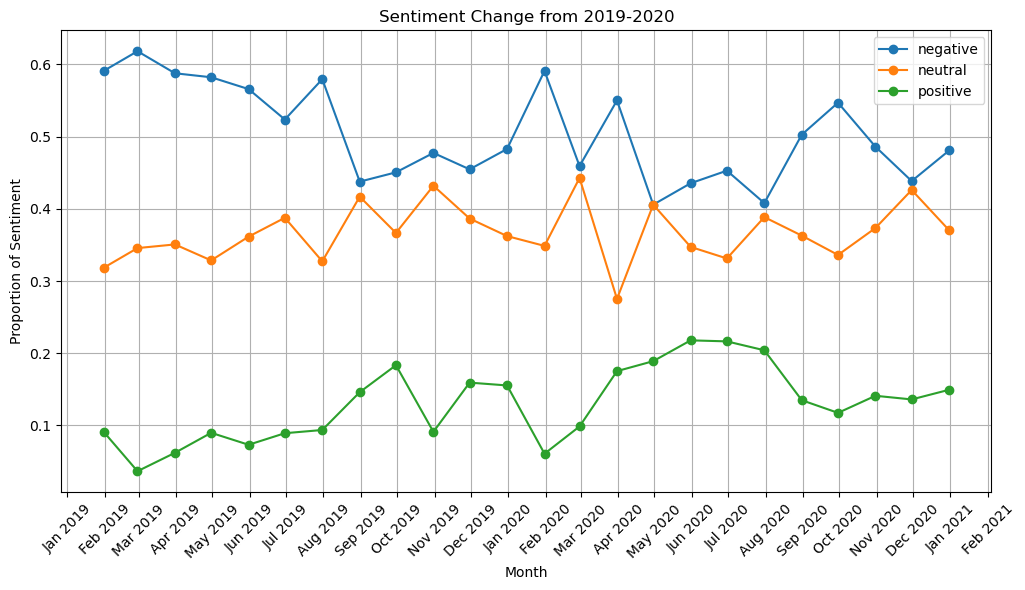

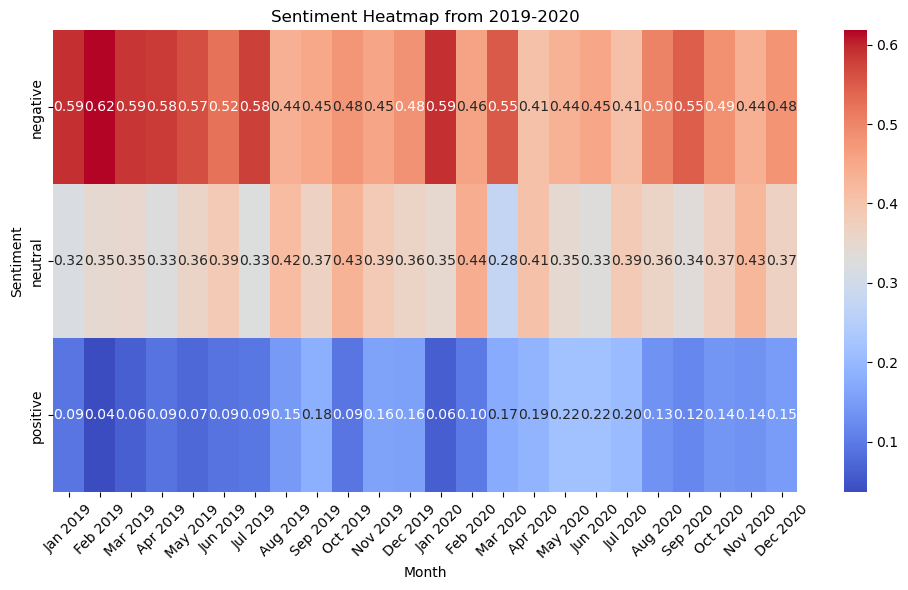

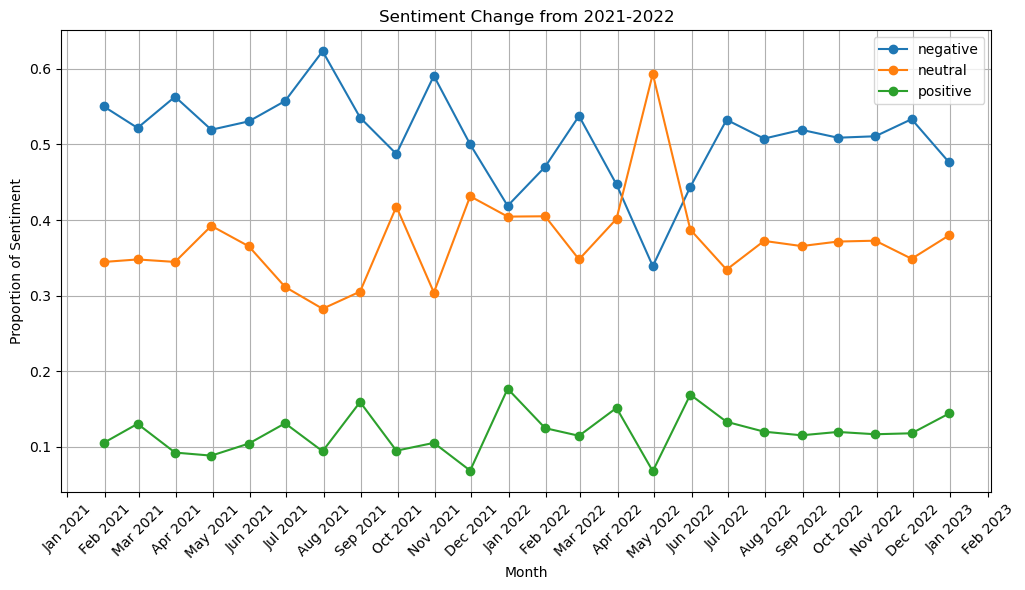

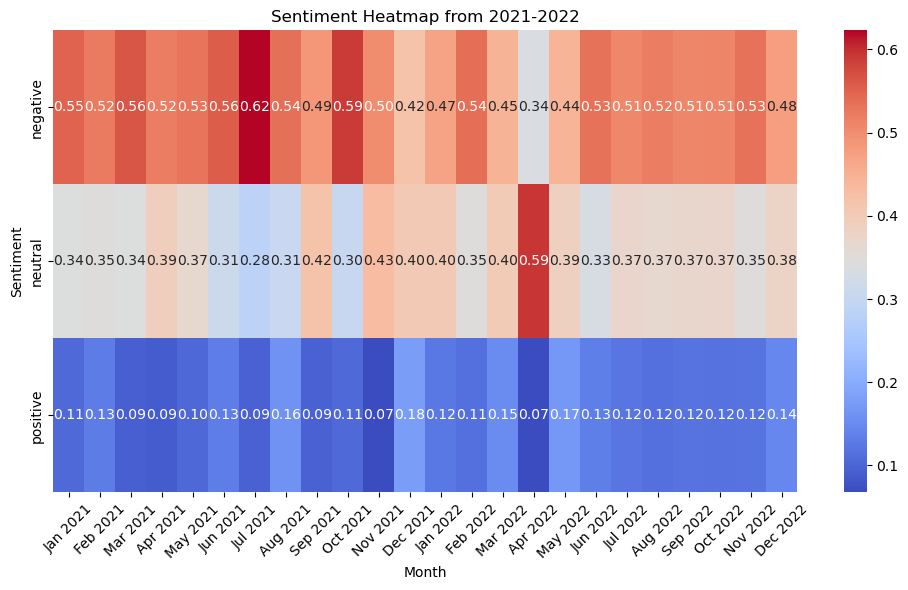

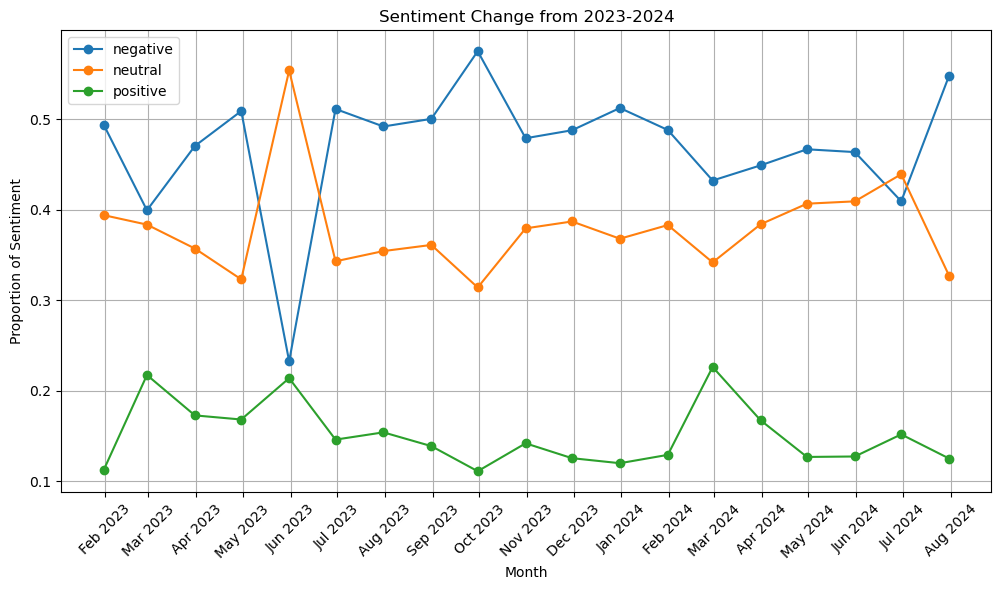

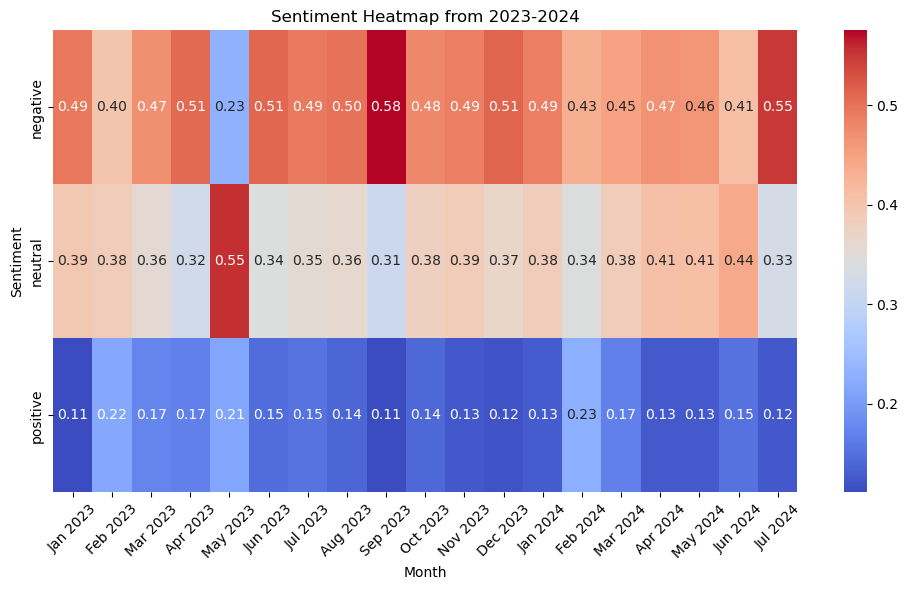

In [125]:
# Convert the created_time to datetime format with the correct format
df['created_time'] = pd.to_datetime(df['created_time'], format='%Y-%m-%d %H:%M:%S')

# Set the created_time as the index
df.set_index('created_time', inplace=True)

# Ensure the index is sorted
df.sort_index(inplace=True)

# Define the periods
periods = {
    '2017-2018': ('2017-01-01', '2018-12-31'),
    '2019-2020': ('2019-01-01', '2020-12-31'),
    '2021-2022': ('2021-01-01', '2022-12-31'),
    '2023-2024': ('2023-01-01', '2024-07-31')
}

# Plot sentiment change for each period
for period_name, (start_date, end_date) in periods.items():
    df_period = df[start_date:end_date]
    
    # Resample by month and get the average sentiment per month
    monthly_sentiment_counts = df_period.groupby([pd.Grouper(freq='M'), 'sentiment']).size().unstack(fill_value=0)
    monthly_sentiment_proportions = monthly_sentiment_counts.div(monthly_sentiment_counts.sum(axis=1), axis=0)
    
    # Plot the sentiment change for the period
    plt.figure(figsize=(12, 6))
    for sentiment in monthly_sentiment_proportions.columns:
        plt.plot(monthly_sentiment_proportions.index, monthly_sentiment_proportions[sentiment], marker='o', label=sentiment)
    plt.title(f'Sentiment Change from {period_name}')
    plt.xlabel('Month')
    plt.ylabel('Proportion of Sentiment')
    plt.legend()
    plt.grid(True)
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    plt.xticks(rotation=45)
    plt.show()

    # Create heat map for sentiment change
    plt.figure(figsize=(12, 6))
    sns.heatmap(monthly_sentiment_proportions.T, cmap='coolwarm', annot=True, fmt=".2f")
    plt.title(f'Sentiment Heatmap from {period_name}')
    plt.xlabel('Month')
    plt.ylabel('Sentiment')
    plt.xticks(rotation=45)
    plt.gca().set_xticklabels([date.strftime('%b %Y') for date in monthly_sentiment_proportions.index], rotation=45)
    plt.show()